In [ ]:
from data_loading import LeJEPADataset
from transforms import make_transforms, make_transforms_test
import torch
import os

# Change to project root directory
os.chdir('..')

# Prepare training data
transform_s1 = make_transforms(2, 120)
transform_s2 = make_transforms(10, 120)
train_dataset = LeJEPADataset(
    'data/BEN_14k/BigEarthNet-S1',
    'data/BEN_14k/BigEarthNet-S2',
    metadata='data/BEN_14k/serbia_metadata.parquet',
    split='train',
    transform_s1=transform_s1,
    transform_s2=transform_s2
)

train_dataset[0]

(tensor([[[[ 6.2626e-01,  5.0229e-01,  2.6199e-01,  ...,  2.2211e-01,
             6.3091e-02,  3.8970e-03],
           [ 5.9798e-01,  4.7777e-01,  2.4147e-01,  ...,  2.6325e-01,
             1.2836e-01,  8.0085e-02],
           [ 4.7125e-01,  3.6216e-01,  1.4326e-01,  ...,  3.9625e-01,
             3.2243e-01,  3.0004e-01],
           ...,
           [ 4.1120e-01,  3.2235e-01,  1.9683e-01,  ..., -3.2168e-01,
            -4.0544e-01, -4.5525e-01],
           [ 3.5624e-01,  3.0443e-01,  2.5002e-01,  ..., -7.1809e-01,
            -7.9760e-01, -8.4262e-01],
           [ 3.5947e-01,  3.2642e-01,  3.0707e-01,  ..., -8.9567e-01,
            -9.7112e-01, -1.0126e+00]],
 
          [[ 2.1132e-01,  1.4889e-01,  4.9725e-02,  ...,  4.8623e-01,
             7.5264e-01,  8.6140e-01],
           [ 2.5187e-01,  2.0831e-01,  1.5198e-01,  ...,  4.6958e-01,
             7.3974e-01,  8.5149e-01],
           [ 3.2859e-01,  3.2347e-01,  3.5295e-01,  ...,  4.1611e-01,
             6.7747e-01,  7.8996e-01],


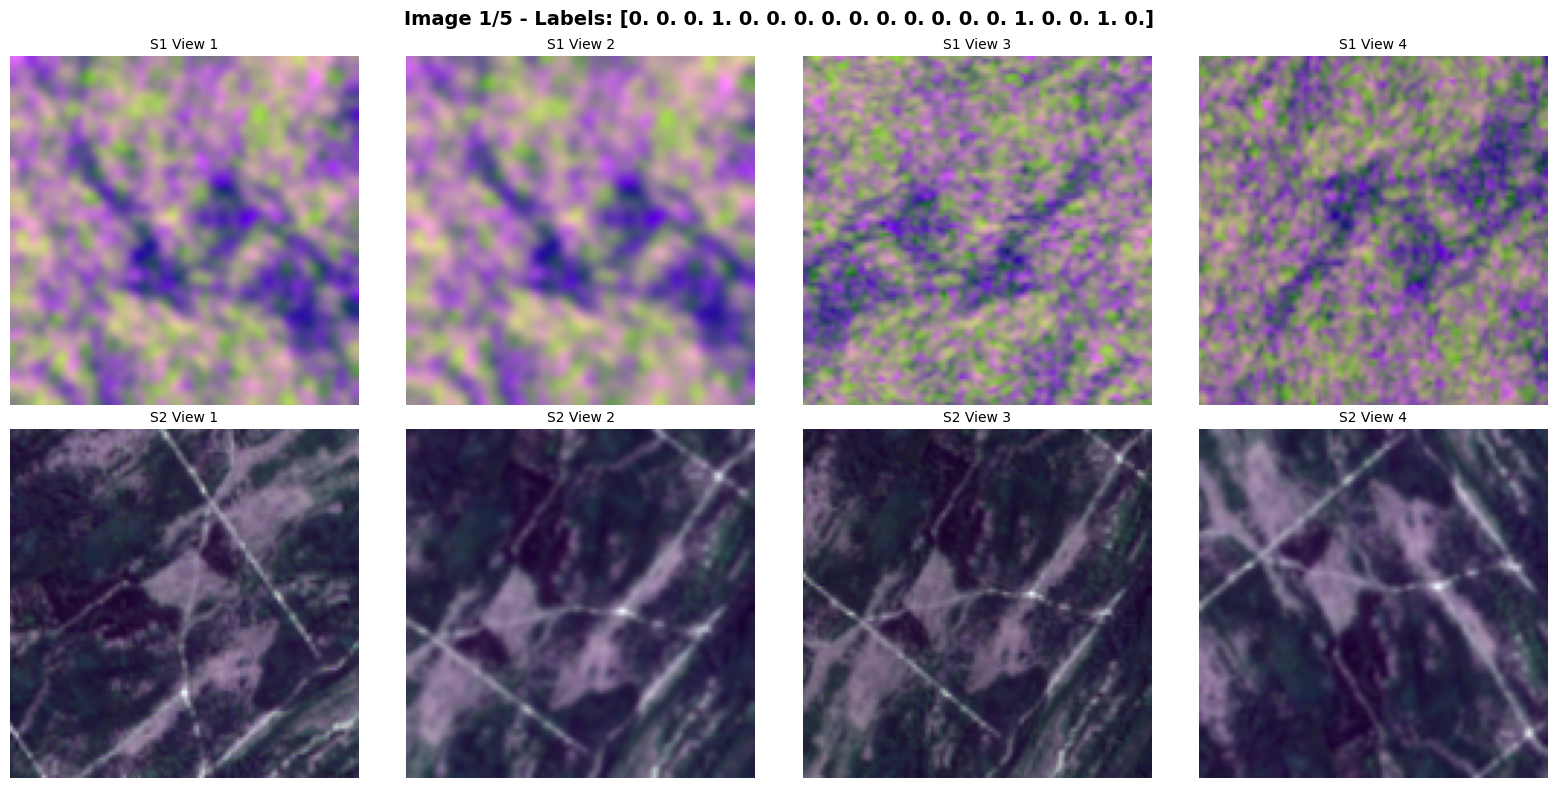

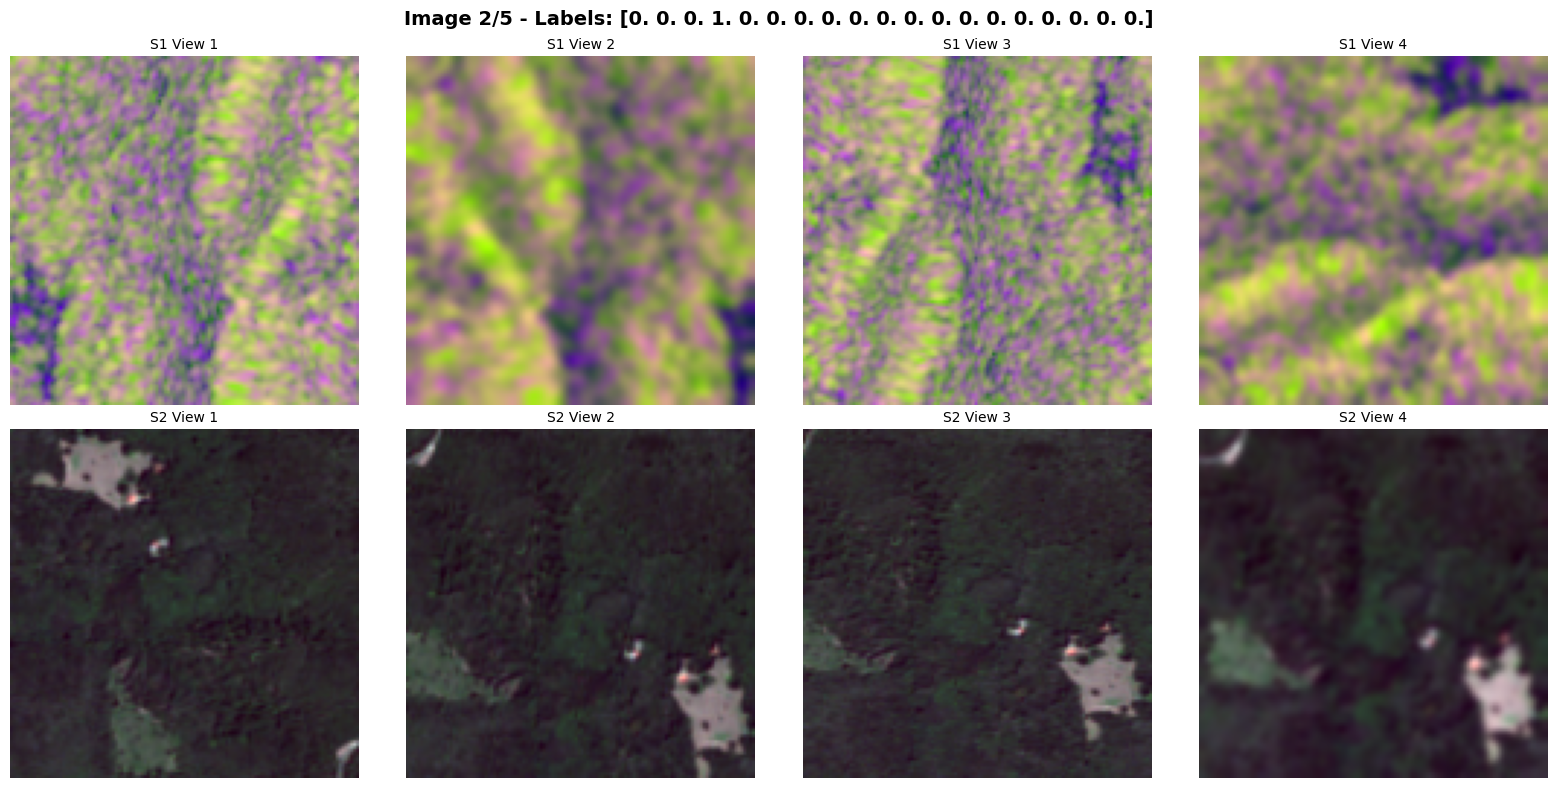

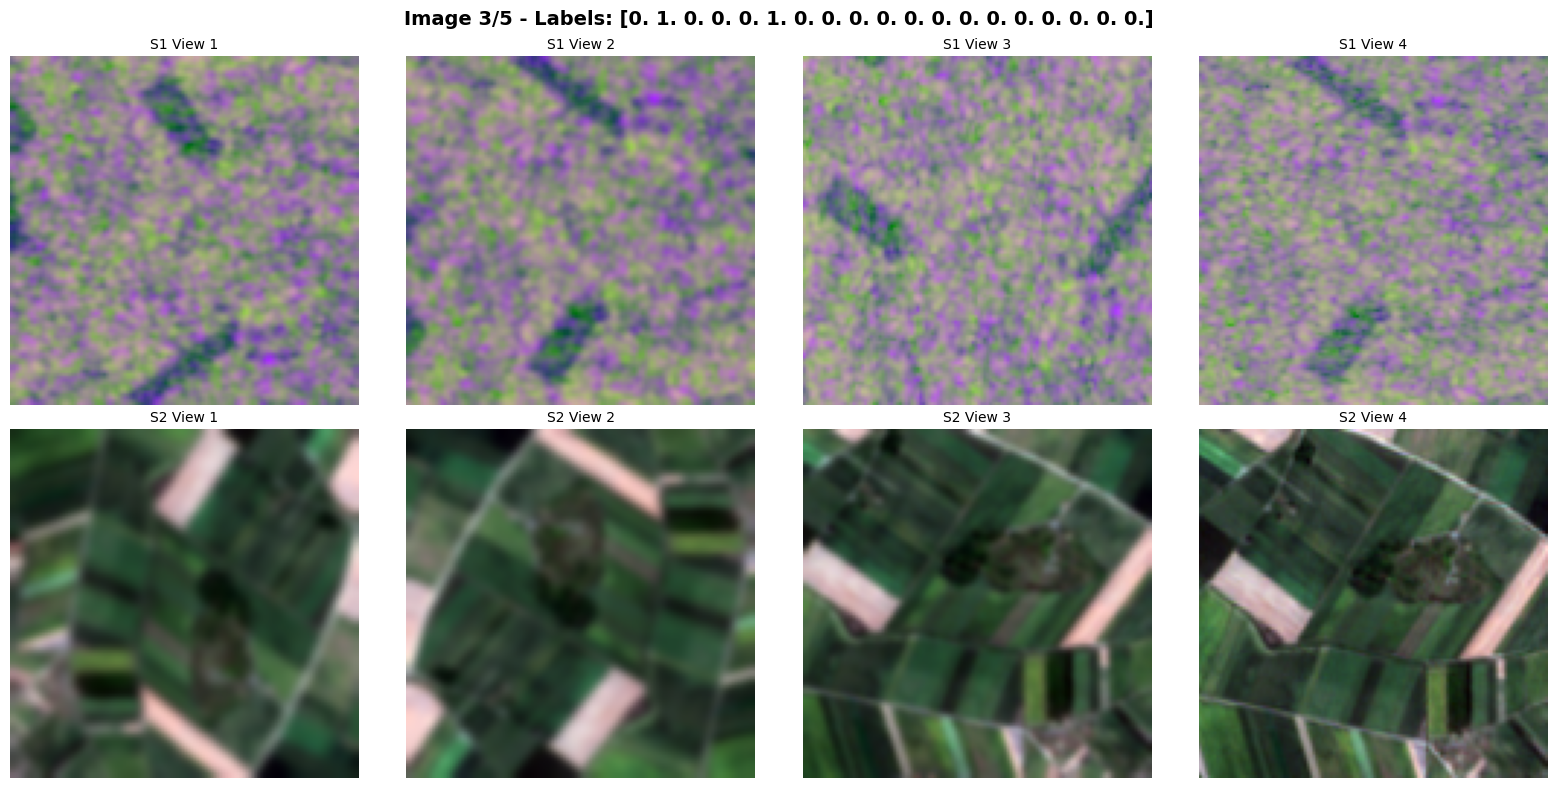

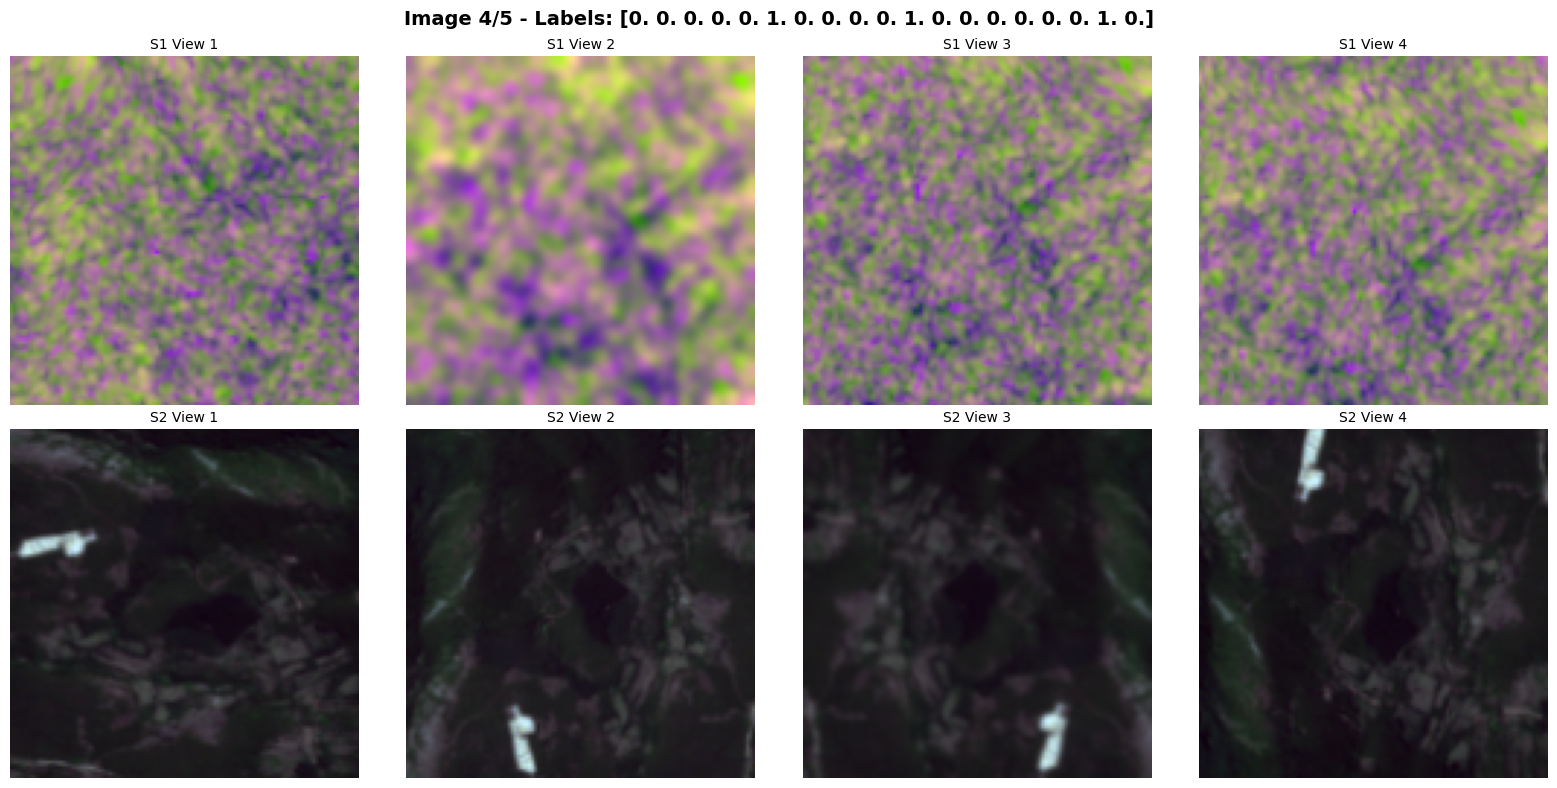

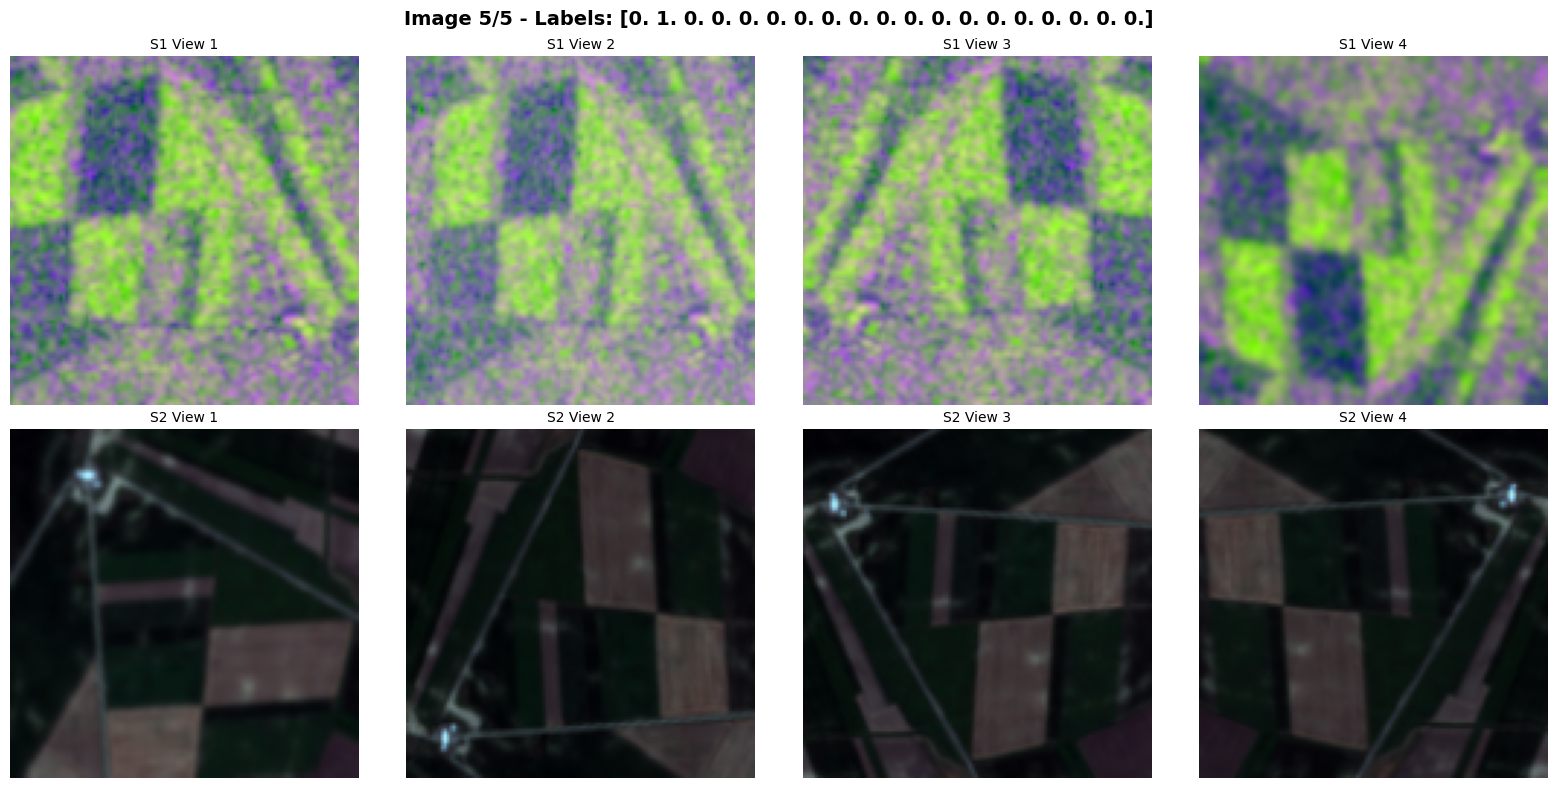

In [3]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Set random seed for reproducibility
random.seed(42)

# Get 5 random indices
num_images = 5
dataset_size = len(train_dataset)
random_indices = random.sample(range(dataset_size), num_images)

# Get the labels from metadata
metadata_df = train_dataset.metadata
metadata_df = metadata_df[metadata_df['split'] == 'train'].reset_index(drop=True)

# Iterate through 5 random images
for img_num, idx in enumerate(random_indices):
    # Get the sample
    views_s1, views_s2, labels = train_dataset[idx]  # views_s1 and views_s2 have shape (V, C, H, W)
    
    # Get label info
    s1_name = train_dataset.metadata1[idx]
    labels_str = str(labels.numpy())
    
    # Create figure with 8 subplots
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f'Image {img_num + 1}/5 - Labels: {labels_str}', fontsize=14, fontweight='bold')
    
    # Plot 4 S1 views (first row)
    for view_idx in range(4):
        s1_view = views_s1[view_idx]  # Shape: (C, H, W)
        
        # Visualize as RGB: VV, VH, VV-VH
        vv = s1_view[0].numpy()
        vh = s1_view[1].numpy()
        vv_vh_ratio = vv - vh
        s1_rgb = np.stack([vv, vh, vv_vh_ratio], axis=-1)
        s1_rgb = (s1_rgb - s1_rgb.min()) / (s1_rgb.max() - s1_rgb.min() + 1e-6)
        
        axes[0, view_idx].imshow(s1_rgb)
        axes[0, view_idx].set_title(f'S1 View {view_idx + 1}', fontsize=10)
        axes[0, view_idx].axis('off')
    
    # Plot 4 S2 views (second row)
    for view_idx in range(4):
        s2_view = views_s2[view_idx]  # Shape: (C, H, W)
        
        # Visualize as RGB: B2, B3, B4 (indices 0, 1, 2)
        rgb = s2_view[[2, 1, 0], :, :].numpy()  # BGR to RGB
        rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)
        rgb = np.transpose(rgb, (1, 2, 0))  # CHW to HWC
        
        axes[1, view_idx].imshow(rgb)
        axes[1, view_idx].set_title(f'S2 View {view_idx + 1}', fontsize=10)
        axes[1, view_idx].axis('off')
    
    plt.tight_layout()
    plt.show()

METADATA OVERVIEW
Shape: (13683, 9)

Columns: ['patch_id', 'labels', 'split', 'country', 's1_name', 's2v1_name', 'contains_seasonal_snow', 'contains_cloud_or_shadow', 'one_hot_labels']

First few rows:
                                            patch_id  \
0  S2A_MSIL2A_20170803T094031_N9999_R036_T34TCR_2...   
1  S2A_MSIL2A_20170803T094031_N9999_R036_T34TCR_2...   
2  S2A_MSIL2A_20170803T094031_N9999_R036_T34TCR_2...   
3  S2A_MSIL2A_20170803T094031_N9999_R036_T34TCR_2...   
4  S2A_MSIL2A_20170803T094031_N9999_R036_T34TCR_2...   

                                              labels       split country  \
0  [Broad-leaved forest, Complex cultivation patt...  validation  Serbia   
1  [Broad-leaved forest, Inland waters, Inland we...  validation  Serbia   
2  [Broad-leaved forest, Complex cultivation patt...  validation  Serbia   
3  [Complex cultivation patterns, Inland waters, ...  validation  Serbia   
4  [Complex cultivation patterns, Inland waters, ...  validation  Serbia   

    

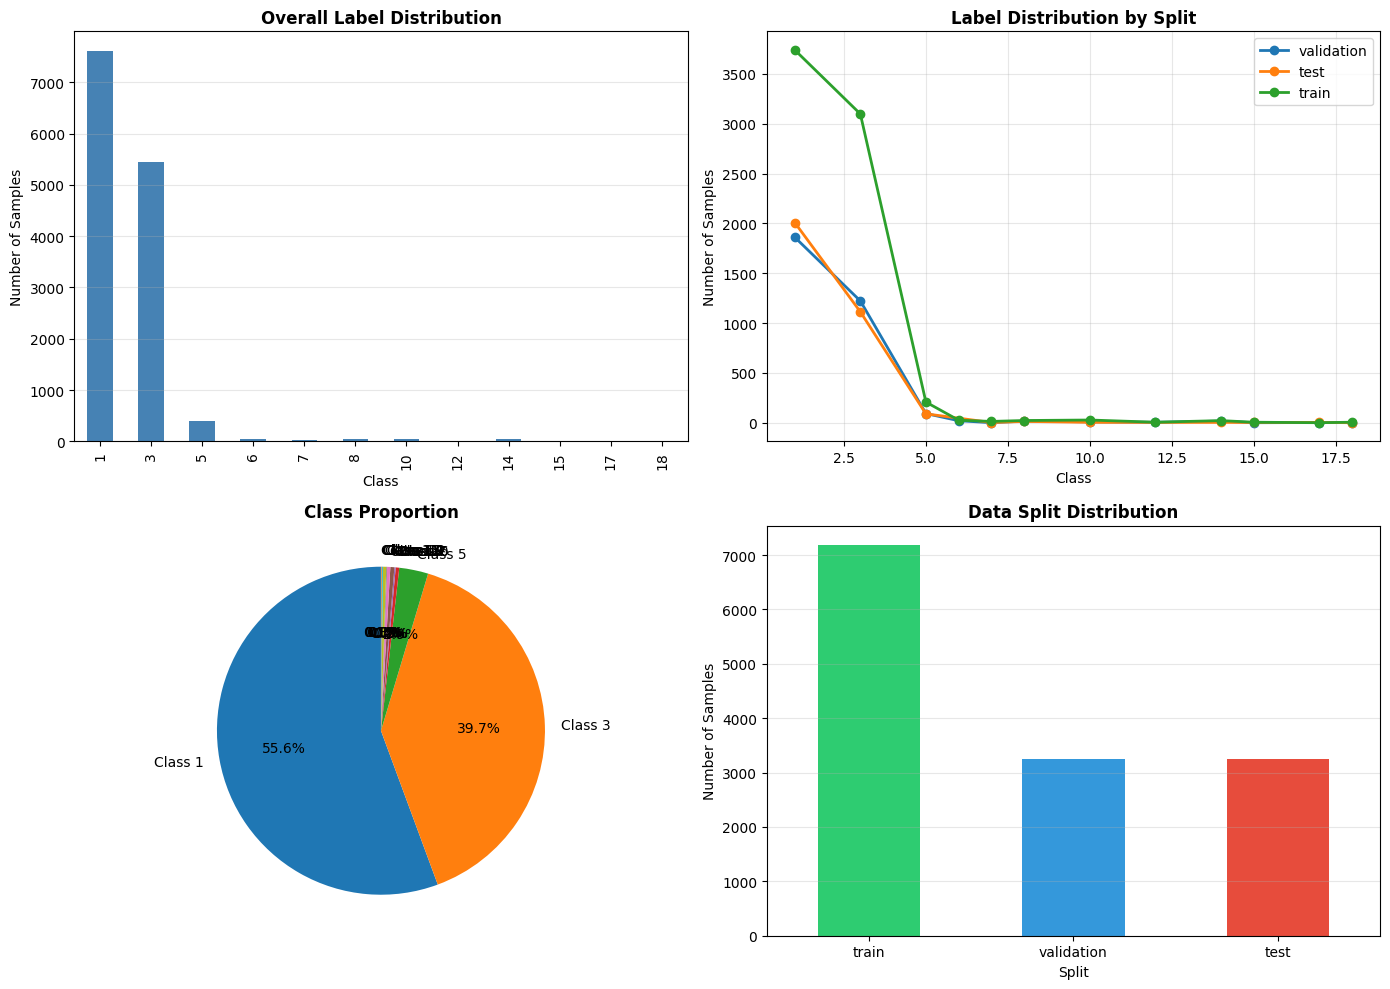

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read the metadata parquet file
metadata_path = 'serbia_metadata.parquet'
metadata = pd.read_parquet(metadata_path)

print("=" * 80)
print("METADATA OVERVIEW")
print("=" * 80)
print(f"Shape: {metadata.shape}")
print(f"\nColumns: {metadata.columns.tolist()}")
print(f"\nFirst few rows:\n{metadata.head()}")

# Check the labels column
print("\n" + "=" * 80)
print("LABEL INFORMATION")
print("=" * 80)

# Convert one_hot_labels to actual labels if needed
def get_class_from_onehot(onehot):
    """Convert one-hot encoded label to class index"""
    if isinstance(onehot, (list, np.ndarray)):
        return np.argmax(onehot)
    return None

metadata['label_class'] = metadata['one_hot_labels'].apply(get_class_from_onehot)

print(f"\nNumber of classes: {metadata['label_class'].nunique()}")
print(f"Class distribution:\n{metadata['label_class'].value_counts().sort_index()}")

# Label distribution by split
print("\n" + "=" * 80)
print("LABEL DISTRIBUTION BY SPLIT")
print("=" * 80)
for split in metadata['split'].unique():
    split_data = metadata[metadata['split'] == split]
    print(f"\n{split.upper()} split:")
    print(f"  Total samples: {len(split_data)}")
    print(f"  Class distribution:\n{split_data['label_class'].value_counts().sort_index()}")

# Calculate metrics
print("\n" + "=" * 80)
print("CLASS BALANCE METRICS")
print("=" * 80)

class_counts = metadata['label_class'].value_counts().sort_index()
print(f"\nClass counts:\n{class_counts}")
print(f"\nClass proportions (%):\n{(class_counts / class_counts.sum() * 100).round(2)}")

# Imbalance ratio (max class / min class)
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nImbalance ratio (max/min): {imbalance_ratio:.2f}")

# Standard deviation of class distribution
std_dev = class_counts.std()
mean_count = class_counts.mean()
print(f"Mean samples per class: {mean_count:.2f}")
print(f"Std dev of class counts: {std_dev:.2f}")
print(f"Coefficient of variation: {(std_dev / mean_count):.3f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Overall class distribution
ax1 = axes[0, 0]
class_counts.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Overall Label Distribution', fontsize=12, fontweight='bold')
ax1.set_xlabel('Class')
ax1.set_ylabel('Number of Samples')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Class distribution by split
ax2 = axes[0, 1]
for split in metadata['split'].unique():
    split_data = metadata[metadata['split'] == split]
    counts = split_data['label_class'].value_counts().sort_index()
    ax2.plot(counts.index, counts.values, marker='o', label=split, linewidth=2)
ax2.set_title('Label Distribution by Split', fontsize=12, fontweight='bold')
ax2.set_xlabel('Class')
ax2.set_ylabel('Number of Samples')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Class proportion pie chart
ax3 = axes[1, 0]
ax3.pie(class_counts.values, labels=[f'Class {i}' for i in class_counts.index], 
        autopct='%1.1f%%', startangle=90)
ax3.set_title('Class Proportion', fontsize=12, fontweight='bold')

# Plot 4: Split distribution
ax4 = axes[1, 1]
split_counts = metadata['split'].value_counts()
split_counts.plot(kind='bar', ax=ax4, color=['#2ecc71', '#3498db', '#e74c3c'])
ax4.set_title('Data Split Distribution', fontsize=12, fontweight='bold')
ax4.set_xlabel('Split')
ax4.set_ylabel('Number of Samples')
ax4.grid(axis='y', alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)